# Banglore home prices analysis

### A simple end to end project:

- Data cleaning and formating
- Exploratory analysis
- Feature engineering and imputation
- Model training and evaluation
- Build a web server with Flask that consumes predictions from the trained model, and a UI (client) with css, html, and js that makes http POST and GET calls to the web server
- Similar to the Zillow Zestimate feature

In [1]:
import sys
import os
from pathlib import Path

'''data'''
import pandas as pd
import numpy as np

'''visualization'''
import matplotlib.pyplot as plt

'''sklearn'''
from sklearn.model_selection import ShuffleSplit

'''models'''
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

'''performance evaluation'''
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

import joblib

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
# Set working directory 
try: INIT_RUN
except NameError:
    os.chdir(os.path.dirname(os.getcwd()))
    INIT_RUN=True

In [3]:
'''custom module'''
from home_price_analysis.config.core import (
    config,
    PROCESSED_DATA_DIR,
    TRAINED_MODEL_DIR)
from home_price_analysis.processing import (
    data_manager as dm,
    features as pp,
    model_helpers as helpers
)
from home_price_analysis.pipeline import price_pipeline
from home_price_analysis import __version__

## Config:

In [47]:
# Execute long processes
EXECUTE = False

## Import data

In [4]:
raw = dm.load_dataset(file_name=config.app_config.RAW_DATA_FILE)

In [5]:
# preprocess data
raw=dm.preprocess_data(raw)

## Train test split

In [6]:
# init the split object
split = ShuffleSplit(n_splits=1,
                     test_size=config.model_config.TEST_SIZE,
                     random_state=config.model_config.RANDOM_STATE)

In [7]:
# Only 1 fold was done since set "n_splits" to 1.
# We shuffle the overall dataset, and then draw 0.8 of the sample to the train set and 0.2 to the test set
for train_index, test_index in split.split(X=raw):
   # We only have one set of train and test index since we only have 1 fold
    train_set = raw.loc[train_index]
    test_set = raw.loc[test_index]

In [8]:
# separate out the features dataframe and outcome series
X_train = train_set[config.model_config.FEATURES]
X_test = test_set[config.model_config.FEATURES]

y_train = np.log(train_set[config.model_config.OUTCOME_VARIABLE])
y_test = np.log(test_set[config.model_config.OUTCOME_VARIABLE])

## Data Processing

In [9]:
# Fit pipeline to train data
tf = price_pipeline.fit(X_train,y_train)

In [10]:
# Transform the train and test datasets
X_train = tf.transform(X_train)
X_test = tf.transform(X_test)

In [11]:
# save the column names of the processed X_train data
feature_columns = X_train.columns.values

In [12]:
# Output processed dataframes

In [13]:
X_train.to_csv(Path(PROCESSED_DATA_DIR,"X_train_processed.csv"))
X_test.to_csv(Path(PROCESSED_DATA_DIR,"X_test_processed.csv"))

y_train.to_csv(Path(PROCESSED_DATA_DIR,"y_train_processed.csv"))
y_test.to_csv(Path(PROCESSED_DATA_DIR,"y_test_processed.csv"))

In [14]:
X_train.shape

(9048, 247)

In [15]:
X_train

,size,total_sqft,bath,area_type_Super_built_up_Area,area_type_Built_up_Area,availability_not_ready_to_move,location_Hennur Road,location_Whitefield,location_Other,location_KR Puram,...,location_NRI Layout,location_Banaswadi,location_LB Shastri Nagar,location_Jalahalli East,location_Nagasandra,location_Prithvi Layout,location_5th Block Hbr Layout,location_Tindlu,location_Sector 2 HSR Layout,location_Banjara Layout
3242,-0.597839,-0.237803,-0.486133,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10912,1.125125,1.660064,1.248305,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6711,-0.597839,-0.303600,-0.486133,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4002,2.848089,0.845716,2.982743,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1918,-0.597839,-0.350598,-0.486133,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9372,-0.597839,-0.393324,-0.486133,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7291,0.263643,0.986710,0.381086,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1344,0.263643,0.760265,0.381086,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7293,1.125125,1.700226,2.115524,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Modelling

## 1- Baseline Model
- A naive guess of what the home prices are. We make the same prediction for each home with the median home prices across the train set.
- A baseline model is a benchmark against which we can compare the performance of other ML approaches. If the performance of ML approaches is only a small improvement over the baseline model, then perhaps ML is not a suitable approach for this problem.

In [16]:
# Init the dummy_regr
dummy_regr = DummyRegressor(strategy="median")
# Train the model
dummy_regr.fit(X_train,y_train)
# Make predictions
y_pred_baseline = dummy_regr.predict(X_test)
print(f"The rmse of the baseline model is {round(mean_squared_error(y_test,y_pred_baseline, squared=False),2)}.")

The rmse of the baseline model is 0.69.


The baseline model has an average percent deviation of 56% from the geometric mean of "price" across all train observations.

## 2- Train linear regression, random forest, and gradient boosting and compared their test rmse (from k-fold cv)

**Init models**

In [17]:
models, names = helpers.get_models()

In [18]:
models,names

([LinearRegression(), RandomForestRegressor(), GradientBoostingRegressor()],
 ['linear_regression', 'random_forest', 'gradient_boosting'])

**Train and evaluate models**

In [19]:
# Train each model, get their estimated test metric using 10-fold CV
# and store the results in a list "l_mean_cv_scores"

l_cv_scores=list()

for model, name in list(zip(models,names)):
    
    # compute the cv scores for each model
    cv_scores = helpers.evaluate_model(X_train, y_train, model)
    
    # Update the list of model results, each row represent the 10 cv scores of a model
    l_cv_scores.append(cv_scores)
    
    # Get mean cv_scores (rmse) of each model
    print((name, round(-cv_scores.mean(),2), round(np.std(cv_scores),2)))

('linear_regression', -0.63, 0.11)
('random_forest', -0.79, 0.02)
('gradient_boosting', -0.78, 0.02)


In [ ]:
# Comparison plot of model performance
fig = plt.figure(figsize=(15,10))
plt.boxplot(l_cv_scores, labels=names, showmeans=True)
plt.ylabel("negative rmse")

**Both Random Forest and Gradient boosted tree has the lowest rmse (higest -rmse). We will tune the gradient boosted to see if we can further improve its predictive performance.**

## 3- Hyperparameter tuning for gradient boosted tree

In [21]:
reg = GradientBoostingRegressor()

**RandomizedSearchCV for gb**

In [22]:
random_grid = {
   "n_estimators": [100, 500, 1000], # number of trees to build
   "learning_rate": [0.01,0.05,0.1], # learning rate
   "max_depth":[4,6,8,10], # maximum depth of each tree
   "subsample":[0.5,0.75,1.0], # prop of train set (observations) to consider for each tree
   "max_features":[0.4,0.6,0.8,1.0] # prop of features to consider for each split
}

In [23]:
# Perform random search of the parameters, using a 10 fold CV to estimate the test metric for each setting.
rand_grid_search = RandomizedSearchCV(estimator = reg,
                                param_distributions = random_grid,
                                n_iter = 20,  # randomly select 20 different settings to try
                                cv = 10,       # use 10-fold CV for each setting to estimate its test metric
                                scoring="neg_root_mean_squared_error",
                                verbose = 1, #2   # show the process
                                n_jobs =-1,  # use all processors
                                random_state = config.model_config.RANDOM_STATE)

In [24]:
rand_grid_search.fit(X_train,y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


RandomizedSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [4, 6, 8, 10],
                                        'max_features': [0.4, 0.6, 0.8, 1.0],
                                        'n_estimators': [100, 500, 1000],
                                        'subsample': [0.5, 0.75, 1.0]},
                   random_state=10, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [25]:
print(f"The mean CV score (rmse) of the best estimator is: {-rand_grid_search.best_score_}")
print(f"The best hyperpaarameters for the gb model from RandomGridSearch is {rand_grid_search.best_params_}") 

The mean CV score (rmse) of the best estimator is: 0.2781831053704834
The best hyperpaarameters for the gb model from RandomGridSearch is {'subsample': 1.0, 'n_estimators': 1000, 'max_features': 0.4, 'max_depth': 6, 'learning_rate': 0.05}


**GridSearchCV for Gradient Boosted trees for fine-tuning**

In [30]:
reg = GradientBoostingRegressor(n_estimators=1000,
                                max_depth=6,
                                subsample=1.0)

In [31]:
param_grid = {
    "learning_rate":[0.03,0.05,0.07],
    "max_depth":[5,6,7],
    "max_features": [0.3,0.4,0.5]
}

In [32]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = reg, 
                           param_grid = param_grid, 
                           cv = 10, 
                           scoring="neg_root_mean_squared_error",
                           verbose =1, # show the process
                           n_jobs = -1)  # n_jobs = -1 means use all processors

In [33]:
grid_search.fit(X_train,y_train)

# The optimal parameter
print(f"The optimal parameter from GridSearchCV is: {grid_search.best_params_}")

# The score of the model with the optimal parameter
print(f"\nThe mean CV score (rmse) of the model with the best parameter is: {-grid_search.best_score_}")
    
# Get the model that uses the "best" hp, trained from the full train set
best_reg = grid_search.best_estimator_
# Make predictions using X_test
y_pred = best_reg.predict(X_test)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
The optimal parameter from GridSearchCV is: {'learning_rate': 0.07, 'max_depth': 6, 'max_features': 0.4}

The mean CV score (rmse) of the model with the best parameter is: 0.2756359162261354


In [34]:
# Evaluate the performance of the model (rmse) with the test set
print(f"The test rmse of the tuned model estimated using the test set is: {round(mean_squared_error(y_test,y_pred,squared=False),2)}")
print(f"The test R2 of the tuned model estimated using the test set is: {round(r2_score(y_test,y_pred),2)}")

The test rmse of the tuned model estimated using the test set is: 0.27
The test R2 of the tuned model estimated using the test set is: 0.84


**A slight improvement after fine-tuning the parameters**

## 4- XGBoost

In [35]:
# xgb uses an optimized data object called DMatrix to improve training performance and spped
dmatrix = xgb.DMatrix(data=X_train, label=y_train) 
params = {'objective':'reg:squarederror'}
cv_results = xgb.cv(dtrain=dmatrix, 

                    params=params, 
                    nfold=10, 
                    metrics={'rmse'})
print('RMSE: %.2f' % cv_results['test-rmse-mean'].min())

RMSE: 0.33


**Hyperparameter tuning**

**RandomizedSearchCV for xgb**

In [36]:
xgbr = xgb.XGBRegressor()

In [37]:
random_grid = {
   "n_estimators":[100,500,1000],
   "learning_rate": [0.01, 0.015, 0.025, 0.05], # learning rate
   "gamma": [0.05,0.1,0.3,0.5,1.0], 
   "max_depth":[3,5,10,15, 20], # maximum depth of each tree
   "subsample":[0.6,0.7,1.0], # prop of train set (observations) to consider for each tree
   "colsample_bytree":[0.6,0.8,1.0] 
}

In [38]:
# Perform random search of the parameters, using a 10 fold CV to estimate the test metric for each setting.
rand_grid_search = RandomizedSearchCV(estimator = xgbr,
                                param_distributions = random_grid,
                                n_iter = 40,  # randomly select 20 different settings to try
                                cv = 10,       # use 10-fold CV for each setting to estimate its test metric
                                scoring="neg_root_mean_squared_error",
                                verbose = 1, #2   # show the process
                                n_jobs =-1,  # use all processors
                                random_state = config.model_config.RANDOM_STATE)

In [39]:
if EXECUTE:
    rand_grid_search.fit(X_train,y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,...
                                          predictor=None, random_state=None,
                                          reg_alpha=None, reg_lambda=None, ...),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.05, 0.1, 0.3, 0.5, 1.0],
                                        'learning_rate': [0.01, 0.015, 0.025,
                                                          0.05],
                                        'max_depth': [3, 5, 10, 15, 20],
                                        'n_estimators': [100, 500, 1000],
                                        'subsample': [0.6, 0.7, 1.0]},
                   random_state=10, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [40]:
if EXECUTE:
    print(f"The mean CV score (rmse) of the best estimator is: {-rand_grid_search.best_score_}")
    print(f"The best hyperpaarameters for the gb model from RandomGridSearch is {rand_grid_search.best_params_}") 

The mean CV score (rmse) of the best estimator is: 0.28126029357403903
The best hyperpaarameters for the gb model from RandomGridSearch is {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.05, 'gamma': 0.05, 'colsample_bytree': 0.6}


**GridSearchCV for xgb for fine-tuning**

In [41]:
reg = xgb.XGBRegressor(n_estimators=500,
                       gamma=0.05,
                       learning_rate=0.015,
                       subsample=1.0,
                       max_depth=20)

In [43]:
param_grid = {
    "colsample_bytree": [0.5,0.6,0.7],
    "learning_rate": [0.05,0.06,0.07]
}

In [44]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = reg, 
                           param_grid = param_grid, 
                           cv = 10, 
                           scoring="neg_root_mean_squared_error",
                           verbose =1, # show the process
                           n_jobs = -1)  # n_jobs = -1 means use all processors

In [45]:
grid_search.fit(X_train,y_train)

# The optimal parameter
print(f"The optimal parameter from GridSearchCV is: {grid_search.best_params_}")

# The score of the model with the optimal parameter
print(f"\nThe mean CV score (rmse) of the model with the best parameter is: {-grid_search.best_score_}")
    
# Get the model that uses the "best" hp, trained from the full train set
best_reg = grid_search.best_estimator_
# Make predictions using X_test
y_pred = best_reg.predict(X_test)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
The optimal parameter from GridSearchCV is: {'colsample_bytree': 0.6, 'learning_rate': 0.05}

The mean CV score (rmse) of the model with the best parameter is: 0.28126029357403903


In [46]:
# Evaluate the performance of the model (rmse) with the test set
print(f"The test rmse of the tuned model estimated using the test set is: {round(mean_squared_error(y_test,y_pred,squared=False),2)}")
print(f"The test R-sq of the tuned model estimated using the test set is: {round(r2_score(y_test,y_pred),2)}")

The test rmse of the tuned model estimated using the test set is: 0.28
The test R-sq of the tuned model estimated using the test set is: 0.83



 **We will use xgb for this project (even though its tuned model has a slightly lower performance than gradient boosted tree)**

## 5- Persist best model

In [48]:
joblib.dump(best_reg,Path(TRAINED_MODEL_DIR,f"home_price_xgb_v_{__version__}.pkl"))

['/Users/hfung/Documents/PycharmProjects/practice_projects/minor/bangalore_home_price_prediction/home_prices_research/home_price_analysis/trained_models/home_price_xgb_v_0.0.1.pkl']

## 6- Feature importance from xgb

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

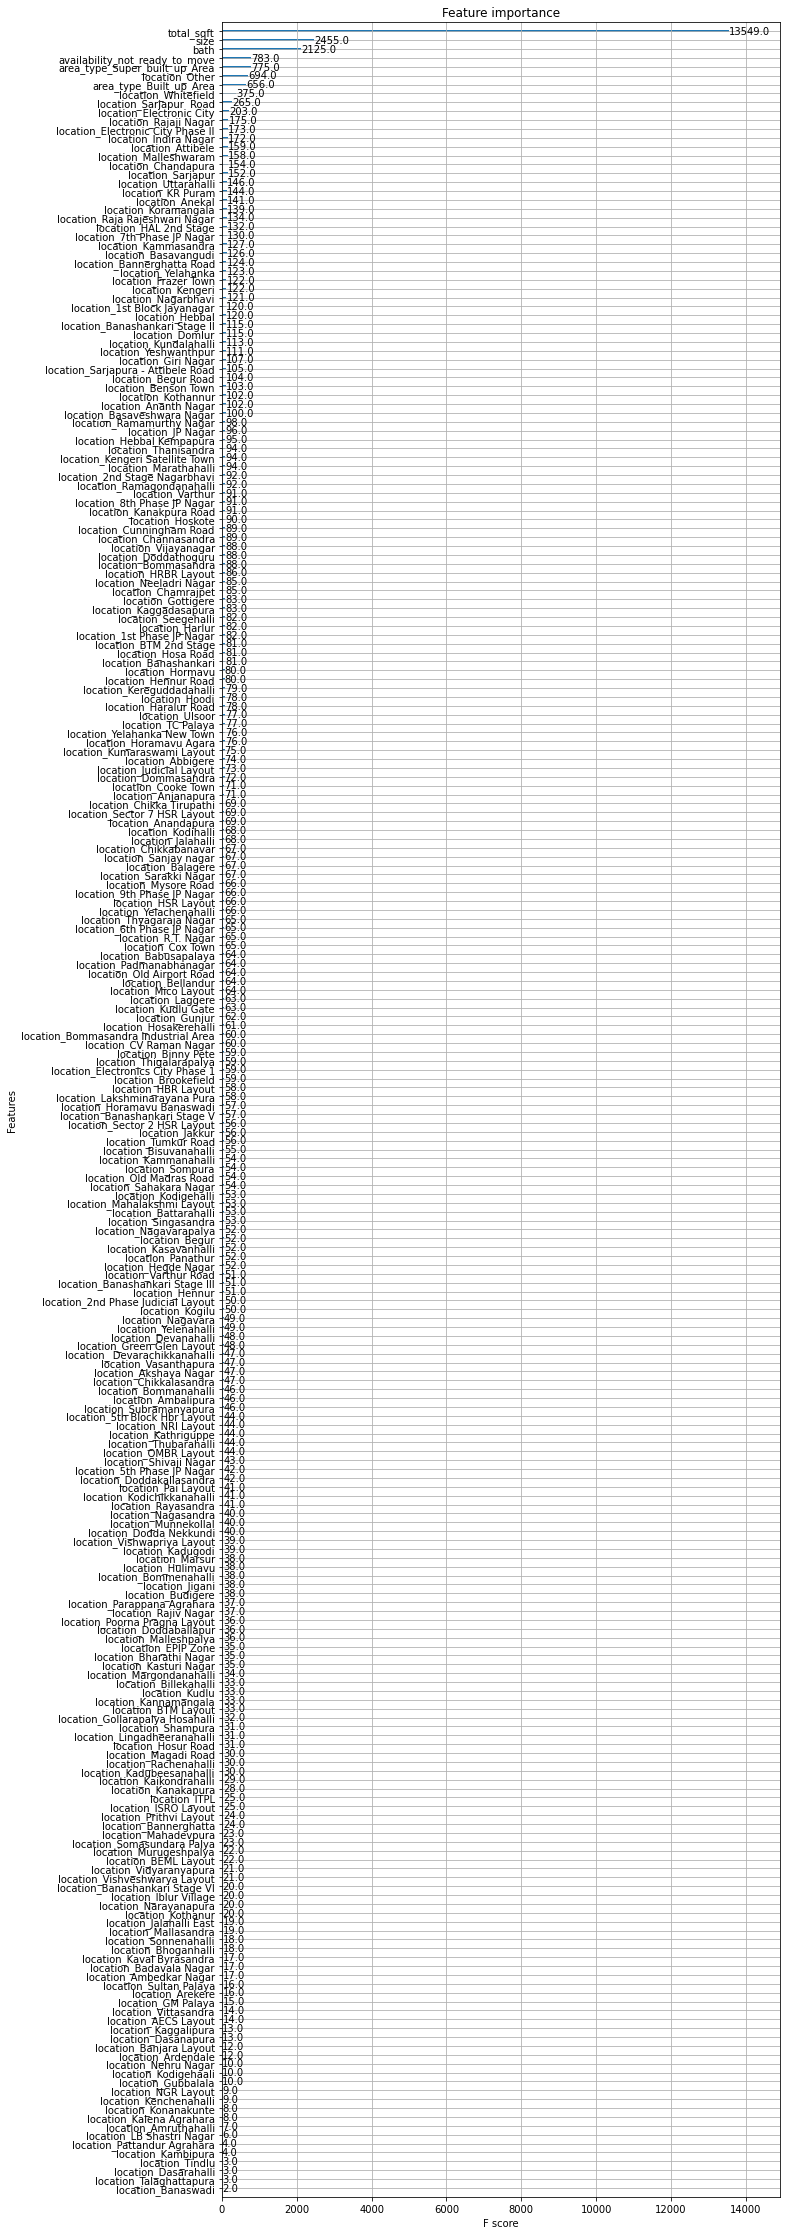

In [52]:
fig = plt.figure(figsize= (10,40))
ax = fig.add_subplot(1,1,1)
xgb.plot_importance(best_reg, ax=ax)

**total_sqft is by far the most important predictor for price**